# Прогнозирование оттока клиентов
### Описание проекта
Цель: Оператору связи необходимо научисться прогнозировать отток клиентов для планирования предиктивных мер (скидок, особых условий).
Для выборки клиентов доступны персональные данные, информация о тарифах и договорах.
Информация о договорах актуальна на 1 февраля 2020.

Основная метрика для проверки качества модели: roc_auc
Дополнительная метрика: accuracy
Описание Услуг
1) Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.<br>
2) Интернет. Подключение может быть двух типов: через телефонную линию DSL или оптоволоконный кабель Fiber optic.

Дополнительные услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
Описание данных
Данные состоят из файлов, полученных из разных источников:<br>

contract.csv — информация о договоре;<br>
personal.csv — персональные данные клиента;<br>
internet.csv — информация об интернет-услугах;<br>
phone.csv — информация об услугах телефонии.<br>


### Исследовательский анализ данных

Подключаем библиотеки:

pandas - для работы с таблицами<br>
seaborn - для визуализации данных<br>
sklearn - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)<br>

In [2]:
import sys
sys.setrecursionlimit(10000)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from tqdm.autonotebook import tqdm

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')


## Предобработка данных

Для всех полей преобразуем данные в удобный для обработки формат (строки в числовые категории, datetime и др.)<br>
При наличии, обработаем пропуски и выбросы

In [4]:
contract

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45


In [5]:
contract.info

<bound method DataFrame.info of              BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                     
7590-VHVEG  2020-01-01                   No  Month-to-month              Yes   
5575-GNVDE  2017-04-01                   No        One year               No   
3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month              Yes   
7795-CFOCW  2016-05-01                   No        One year               No   
9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month              Yes   
...                ...                  ...             ...              ...   
6840-RESVB  2018-02-01                   No        One year              Yes   
2234-XADUH  2014-02-01                   No        One year              Yes   
4801-JZAZL  2019-03-01                   No  Month-to-month              Yes   
8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month              Yes   
3186-AJI

In [6]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [7]:
contract['BeginDate'] = contract['BeginDate'].astype('datetime64')

In [8]:
UPLOAD_DATE = '2020-02-01'
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = UPLOAD_DATE
contract['EndDate'] = contract['EndDate'].astype('datetime64')

In [9]:
# contract['TotalCharges'] = contract['TotalCharges'].astype('float64')
print(f"Количество незаполненных полей TotalCharges: {len(contract.loc[contract['TotalCharges'] == ' '])}")
beg_date = contract.loc[contract['TotalCharges'] == ' ', 'BeginDate'].unique()
print(f"Значения BeginDate для пользователей с пустым TotalCharges: {beg_date}")

Количество незаполненных полей TotalCharges: 11
Значения BeginDate для пользователей с пустым TotalCharges: ['2020-02-01T00:00:00.000000000']


В поле TotalCharges значения пропущения для пользователей, подключенных к тарифу в день выгрузки базы данных (2020-02-01). Эти пользователи не интересны для исследования, их мало (11 клиентов), удалим их из выборки.

In [10]:
contract = contract.loc[contract['TotalCharges'] != ' ']
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#Преобразуем поле Type: 0 - Month-to-month, 1 - One year, 2 - Two year
def transform_type(ptype):
    if ptype == 'Month-to-month' :
        res = 0
    elif ptype == 'One year' :
        res = 1
    elif ptype == 'Two year' :
        res = 2
    return res
contract['Type'] = contract['Type'].apply(transform_type).astype('int8')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [12]:
def transform_payment_method(pmethod):
    if pmethod == 'Electronic check' :
        res = 0
    elif pmethod == 'Mailed check' :
        res = 1
    elif pmethod == 'Bank transfer (automatic)' :
        res = 2
    elif pmethod == 'Credit card (automatic)' :
        res = 3
    return res
contract['PaymentMethod'] = contract['PaymentMethod'].apply(transform_payment_method).astype('int8')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [13]:
contract['PaperlessBilling'] = (contract['PaperlessBilling'] == 'Yes').astype('int8')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
contract['begin_days'] = (pd.Timestamp(UPLOAD_DATE) - contract['BeginDate']) // np.timedelta64(1, 'D')
contract.drop('BeginDate', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
contract['end_days'] = (pd.Timestamp(UPLOAD_DATE) - contract['EndDate']) // np.timedelta64(1, 'D')
contract.drop('EndDate', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
contract['churn'] = (contract['end_days'] > 0).astype('int8')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
contract.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,churn
customerID,,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31,0,0
5575-GNVDE,1,0,1,56.95,1889.50,1036,0,0
3668-QPYBK,0,1,1,53.85,108.15,123,62,1
7795-CFOCW,1,0,2,42.30,1840.75,1371,0,0
9237-HQITU,0,1,0,70.70,151.65,153,92,1


Personal

In [18]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [19]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [20]:
personal['if_male'] = (personal['gender'] == 'Male').astype('int8')
personal.drop('gender', axis=1, inplace=True)

In [21]:
personal['Partner'] = (personal['Partner'] == 'Yes').astype('int8')
personal['Dependents'] = (personal['Dependents'] == 'Yes').astype('int8')


In [22]:
personal.head()

,SeniorCitizen,Partner,Dependents,if_male
customerID,,,,
7590-VHVEG,0,1,0,0
5575-GNVDE,0,0,0,1
3668-QPYBK,0,0,0,1
7795-CFOCW,0,0,0,1
9237-HQITU,0,0,0,0


internet

In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(7)
memory usage: 344.8+ KB


In [24]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [25]:
internet['fiber_optic'] = (internet['InternetService'] == 'Fiber optic').astype('int8')
internet.drop('InternetService', axis=1, inplace=True)

In [26]:
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    internet[col] = (internet[col] == 'Yes').astype('int8')

In [27]:
internet.head()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic
customerID,,,,,,,
7590-VHVEG,0,1,0,0,0,0,0
5575-GNVDE,1,0,1,0,0,0,0
3668-QPYBK,1,1,0,0,0,0,0
7795-CFOCW,1,0,1,1,0,0,0
9237-HQITU,0,0,0,0,0,0,1


phone

In [28]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
MultipleLines    6361 non-null object
dtypes: object(1)
memory usage: 99.4+ KB


In [29]:
phone['MultipleLines'] = (phone['MultipleLines'] == 'Yes').astype('int8')

In [30]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,0
3668-QPYBK,0
9237-HQITU,0
9305-CDSKC,1
1452-KIOVK,1


Объединим таблицы

При объединении таблиц заполним пустые значения признаков -1. Будем считать, что клиент не пользуется данными услугами.

In [31]:
df = contract.join(personal, how='left').join(internet, how='left').join(phone, how='left').fillna(-1)
for col in list(internet.columns) + list(phone.columns):
    df[col] = df[col].fillna(-1).astype('int8')
df = pd.concat([df['churn'], df.drop('churn', axis=1)], axis=1)
df.head(10)

,churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,SeniorCitizen,Partner,Dependents,if_male,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,29.85,29.85,31,0,0,1,0,0,0,1,0,0,0,0,0,-1
5575-GNVDE,0,1,0,1,56.95,1889.50,1036,0,0,0,0,1,1,0,1,0,0,0,0,0
3668-QPYBK,1,0,1,1,53.85,108.15,123,62,0,0,0,1,1,1,0,0,0,0,0,0
7795-CFOCW,0,1,0,2,42.30,1840.75,1371,0,0,0,0,1,1,0,1,1,0,0,0,-1
9237-HQITU,1,0,1,0,70.70,151.65,153,92,0,0,0,0,0,0,0,0,0,0,1,0
9305-CDSKC,1,0,1,0,99.65,820.50,337,92,0,0,0,0,0,0,1,0,1,1,1,1
1452-KIOVK,0,0,1,3,89.10,1949.40,671,0,0,0,1,1,0,1,0,0,1,0,1,1
6713-OKOMC,0,0,0,1,29.75,301.90,306,0,0,0,0,0,1,0,0,0,0,0,0,-1
7892-POOKP,1,0,1,0,104.80,3046.05,945,92,0,1,0,0,0,0,1,1,1,1,1,1


### Произведем отбор признаков

In [32]:
df.describe()

,churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,SeniorCitizen,Partner,Dependents,if_male,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic,MultipleLines
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,0.688567,0.592719,1.315557,64.798208,2283.300441,1008.031428,20.492890,0.162400,0.482509,0.298493,0.504693,0.070392,0.128697,0.127702,0.073948,0.168231,0.172213,0.224118,0.325228
std,0.441782,0.832934,0.491363,1.149523,30.085974,2266.771362,736.095040,38.301177,0.368844,0.499729,0.457629,0.500014,0.705562,0.737917,0.737415,0.707715,0.756518,0.758252,0.778643,0.642585
min,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,35.587500,401.450000,306.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,70.350000,1397.475000,883.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,2.000000,89.862500,3794.737500,1706.000000,31.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,2314.000000,123.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


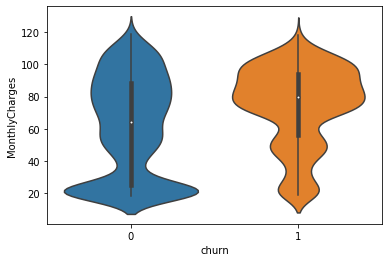

In [33]:
sns.violinplot(x='churn', y='MonthlyCharges', data=df)

Разделим MonthlyCharges на два признака: оплата дешевых тарифов (< 38) и оплата дорогих тарифов (>= 38)


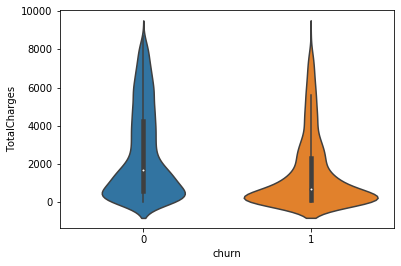

In [34]:
sns.violinplot(x='churn', y='TotalCharges', data=df)


На графиках "violin" видно, что в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся. 

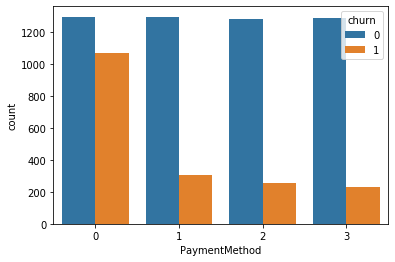

In [35]:
sns.countplot(x='PaymentMethod', hue='churn', data=df)


Многие ушедшие клиенты расплачивались методом 'Electronic check'.

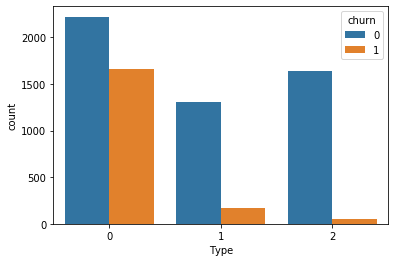

In [36]:
sns.countplot(x='Type', hue='churn', data=df)

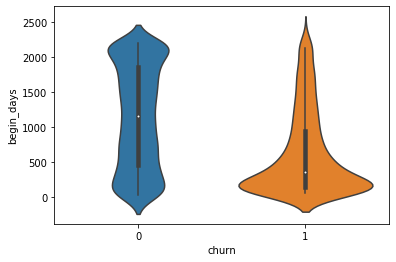

In [37]:
sns.violinplot(x='churn', y='begin_days', data=df)

Большое количество клиентов стали пользоваться услугами в последний год.

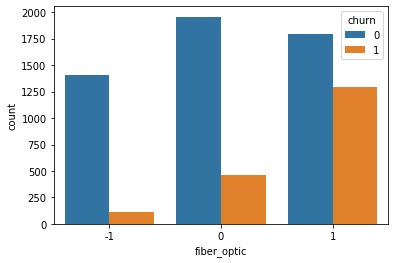

In [38]:
sns.countplot(x='fiber_optic', hue='churn', data=df)

Многие ушедшие клиенты были подключены по оптоволокну.
Среди клиентов, не пользовавшихся услугами интернета (fiber_optic = -1), отток сравнительно небольшой

Матрица корреляции

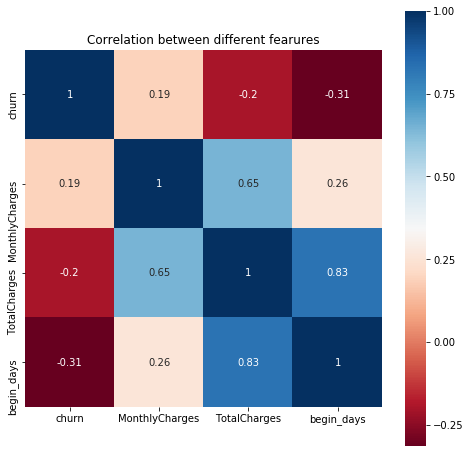

In [39]:
#Построим матрицу корреляции для количественных признаков
cor_columns = ['churn', 'MonthlyCharges', 'TotalCharges', 'begin_days']
correlation = df[cor_columns].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='RdBu')

plt.title('Correlation between different fearures')
plt.show()

In [40]:
#Добавим признак 'service_days' - количество месяцев пользования сервисами.

df['lifetime'] = df['begin_days'] - df['end_days']

In [41]:
df.drop(['begin_days', 'end_days', 'if_male'], axis=1, inplace=True)

In [42]:
num_columns = ['MonthlyCharges', 'TotalCharges', 'lifetime']
cat_columns = [col for col in list(df.columns) if col not in num_columns and col != 'churn']

In [43]:
df.head()

,churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic,MultipleLines,lifetime
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,29.85,29.85,0,1,0,0,1,0,0,0,0,0,-1,31
5575-GNVDE,0,1,0,1,56.95,1889.50,0,0,0,1,0,1,0,0,0,0,0,1036
3668-QPYBK,1,0,1,1,53.85,108.15,0,0,0,1,1,0,0,0,0,0,0,61
7795-CFOCW,0,1,0,2,42.30,1840.75,0,0,0,1,0,1,1,0,0,0,-1,1371
9237-HQITU,1,0,1,0,70.70,151.65,0,0,0,0,0,0,0,0,0,1,0,61


### Вывод
Мы обработали данные, избавились от выбросов, перевели строки в столбцах к нужным типам данных.
Провели анализ данных.
Построили матрицу корреляции и выбрали наиболее подходящие признаки.

План работ<br>
1. Исследовательский анализ данных<br>
 1.1 Загрузка данных<br>
 1.2 Предобработка данных<br>
 1.3 Анализ данных и отбор признаков<br>
2. Выбор и обучение модели<br>
 2.1 Base-line модель<br>
 2.2 Логистическая регрессия<br>
 2.3 Random Forest<br>
 2.4 Градиентный бустинг (CatBoost)<br>
3. Общий вывод<br>



<div class="alert alert-success">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ ТИМЛИДА</u></b>
<font color='green'><br>

План принят, вижу что уже начата работа, продолжай!
</div>

## Выбор и обучение модели

In [44]:

X = df.drop('churn', axis=1)
y = df['churn']

In [45]:
#Разделим данные на тренировочную и тестовую выборку в соотношении 4:1. При разделении учтем баланс классов целевого признака.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (5625, 17)
Размер тестовой выборки: (1407, 17)


### Base-line модель

В качестве base-line моделей используем константную модель (все объекты класса 0, соответствующего оставшимся клиентам).
Также обучим модель логистической регрессии

In [47]:
pred_bl = [0] * y.shape[0]
roc_auc_bl = roc_auc_score(y.values, pred_bl)
print(f"roc_auc для константной модели: {roc_auc_bl:.3f}")
accuracy_bl = accuracy_score(y.values, pred_bl)
print(f"accuracy для константной модели: {accuracy_bl:.3f}")

roc_auc для константной модели: 0.500
accuracy для константной модели: 0.734


### Логистическая регрессия

In [48]:
# Scale data
ss = StandardScaler()
ss.fit(X_train)
X_train_s = pd.DataFrame(ss.transform(X_train), columns = X_train.columns)
X_test_s = pd.DataFrame(ss.transform(X_test), columns = X_test.columns, index=X_test.index)

In [49]:
# Logistic regression
model_lr = LogisticRegression(C=0.5)
roc_auc_lr_v = cross_val_score(model_lr, X_train_s, y_train, cv=5, scoring='roc_auc').mean()
print(f"roc_auc для модели Логистической Регрессии на кросс-валидации: {roc_auc_lr_v:.3f}")
accuracy_lr = cross_val_score(model_lr, X_train_s, y_train, cv=5, scoring='accuracy').mean()
print(f"accuracy для модели Логистической Регрессии: {accuracy_lr:.3f}")

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

roc_auc для модели Логистической Регрессии на кросс-валидации: 0.846


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy для модели Логистической Регрессии: 0.802


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Random-Forest 

In [50]:
#Лучшие параметры подберем используя GrindSearchCV
param_grid = {'n_estimators': [300],
              'max_depth': [5, 7, 9],
              'max_features': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [2, 4, 6],
             }

model_lr = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator = model_lr,
                           param_grid = param_grid,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2,
                           scoring = 'roc_auc')
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300, total=   0.6s
[CV] max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300, total=   0.6s
[CV] max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300 
[CV]  max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300, total=   0.6s
[CV] max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300 
[CV]  max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300, total=   0.7s
[CV] max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300 
[CV]  max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300, total=   0.6s
[CV] max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300 
[CV]  max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300, total=   0.6s
[CV] max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=

[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  3.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [51]:
print('model params: ', grid_search_rf.best_params_)
print(f"roc_auc для модели Random Forest на кросс валидации: {grid_search_rf.best_score_:.3f}")

pred_rf = grid_search_rf.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_rf_t = roc_auc_score(y_test, pred_rf)
print(f"roc_auc для модели Random Forest на тестовой выборке: {roc_auc_rf_t:.3f}")

model params:  {'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}
roc_auc для модели Random Forest на кросс валидации: 0.864
roc_auc для модели Random Forest на тестовой выборке: 0.860


In [52]:
accuracy_rf_t = accuracy_score(y_test, grid_search_rf.best_estimator_.predict(X_test))
print(f"accuracy для модели Random Forest на тестовой выборке: {accuracy_rf_t:.3f}")

accuracy для модели Random Forest на тестовой выборке: 0.816


### CatBoost Модель

In [53]:
model_cb = CatBoostClassifier(
    iterations = 2000,
    learning_rate = 0.02,
    depth = 3,
#     l2_leaf_reg = 8,
    loss_function='CrossEntropy',
    eval_metric = 'AUC',
    cat_features = cat_columns, 
#     auto_class_weights='Balanced',
    random_state=42,
    )

In [54]:
X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [55]:
model_cb.fit(X_train_v, y_train_v, 
                use_best_model=True, 
                eval_set=(X_valid, y_valid),
                logging_level = 'Verbose',
                cat_features=cat_columns,
                )

0:	test: 0.7453707	best: 0.7453707 (0)	total: 52.5ms	remaining: 1m 44s
1:	test: 0.7623530	best: 0.7623530 (1)	total: 56.9ms	remaining: 56.8s
2:	test: 0.7687088	best: 0.7687088 (2)	total: 70.8ms	remaining: 47.2s
3:	test: 0.7806464	best: 0.7806464 (3)	total: 109ms	remaining: 54.4s
4:	test: 0.7854906	best: 0.7854906 (4)	total: 121ms	remaining: 48.1s
5:	test: 0.7890781	best: 0.7890781 (5)	total: 208ms	remaining: 1m 9s
6:	test: 0.7972690	best: 0.7972690 (6)	total: 224ms	remaining: 1m 3s
7:	test: 0.7968406	best: 0.7972690 (6)	total: 303ms	remaining: 1m 15s
8:	test: 0.7964562	best: 0.7972690 (6)	total: 318ms	remaining: 1m 10s
9:	test: 0.8058896	best: 0.8058896 (9)	total: 398ms	remaining: 1m 19s
10:	test: 0.8106626	best: 0.8106626 (10)	total: 410ms	remaining: 1m 14s
11:	test: 0.8147833	best: 0.8147833 (11)	total: 416ms	remaining: 1m 8s
12:	test: 0.8175088	best: 0.8175088 (12)	total: 494ms	remaining: 1m 15s
13:	test: 0.8188859	best: 0.8188859 (13)	total: 506ms	remaining: 1m 11s
14:	test: 0.8197

In [56]:

print(f"roc_auc для модели CatBoost на валидационной выборке: {model_cb.best_score_['validation']['AUC']:.3f}")

roc_auc для модели CatBoost на валидационной выборке: 0.890


In [57]:
model_cb.fit(X_train, y_train, 
             cat_features=cat_columns,
             logging_level = 'Silent',
            )

In [58]:
roc_auc_cb = roc_auc_score(y_test, model_cb.predict_proba(X_test)[:, 1])
print(f"roc_auc для модели CatBoost на тестовой выборке: {roc_auc_cb:.3f}")

roc_auc для модели CatBoost на тестовой выборке: 0.894


In [59]:
accuracy_cb_t = accuracy_score(y_test, model_cb.predict(X_test))
print(f"accuracy для модели CatBoost на тестовой выборке: {accuracy_cb_t:.3f}")

accuracy для модели CatBoost на тестовой выборке: 0.839


## Общий вывод

Мы провели исследовательский анализ данных, по итогам которого выявили, что: <br>
<li>в среднем, клиенты которые ушли, платили ежемесячно больше, чем те, которые остались</li>
<li>Большое количество клиентов, которые ушли, расплачивались методом Electronic Check</li>
<li>Клиенты которые не пользовались услугами интернета (fiber_optic = -1), имеют сравнительно небольшой отток</li>
Мы обучили различные модели бинарной классификации для предсказания оттока клиентов. Для проверки качества моделей использовались метрики roc_auc и accuracy.<br>
Самое лучшее качество предсказания показала модель градиентного бустинга (CatBoost). roc_auc = 0.894 на тестовой выборке, accuracy = 0.839
